## Comparing HITEMP and ExoMol

In [59]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec.exomol import gamma_exomol
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of par file.
If the par file does not exist, moldb will try to download it from HITRAN website.

In [3]:
# Setting wavenumber bins and loading HITEMP database
wav=np.linspace(22930.0,23000.0,4000,dtype=np.float64) #AA
nus=1.e8/wav[::-1] #cm-1
mdbCO_HITEMP=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_HITEMP2019.par.bz2',nus)

https://www.cfa.harvard.edu/HITRAN/HITRAN2012/HITRAN2012/By-Molecule/Uncompressed-files/05_HITEMP2019.par.bz2
HITRAN download failed
https://hitran.org/hitemp/data/bzip2format/05_HITEMP2019.par.bz2
bunziping


In [5]:
emf='/home/kawahara/exojax/data/CO/12C-16O/Li2015'
mdbCO_Li2015=moldb.MdbExomol(emf,nus)

Mol mass= 28.0101
gamma width= 0.07
T exponent= 0.5
Note: Couldn't find the feather format. We convert data to the feather format. After the second time, it will become much faster.
Reading transition file
Note: Couldn't find the feather format. We convert data to the feather format. After the second time, it will become much faster.


Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [62]:
from exojax.spec import molinfo
Mmol=molinfo.molmass("CO") # molecular weight
Tfix=1300.0 # we assume T=1300K
Pfix=0.99 # we compute P=1 bar=0.99+0.1
Ppart=0.01 #partial pressure of CO. here we assume a 1% CO atmosphere (very few). 

partition function ratio $q(T)$ is defined by 

$q(T) = Q(T)/Q(T_{ref})$; $T_{ref}$=296 K

Here, we use the partition function from HAPI

In [63]:
mdbCO_HITEMP.ExomolQT(emf) #use Q(T) from Exomol/Li2015
qt_HITEMP=mdbCO_HITEMP.qr_interp(Tfix)
qt_Li2015=mdbCO_Li2015.qr_interp(Tfix)

Let us compute the line strength S(T) at temperature of Tfix.

$S (T;s_0,\nu_0,E_l,q(T)) = S_0 \frac{Q(T_{ref})}{Q(T)} \frac{e^{- h c E_l /k_B T}}{e^{- h c E_l /k_B T_{ref}}} \frac{1- e^{- h c \nu /k_B T}}{1-e^{- h c \nu /k_B T_{ref}}}= q_r(T)^{-1} e^{ s_0 - c_2 E_l (T^{-1} - T_{ref}^{-1})}  \frac{1- e^{- c_2 \nu_0/ T}}{1-e^{- c_2 \nu_0/T_{ref}}}$

$s_0=\log_{e} S_0$ : logsij0

$\nu_0$: nu_lines

$E_l$ : elower

Why the input is $s_0 = \log_{e} S_0$ instead of $S_0$ in SijT? This is because the direct value of $S_0$ is quite small and we need to use float32 for jax.  

In [64]:
Sij_HITEMP=SijT(Tfix,mdbCO_HITEMP.logsij0,mdbCO_HITEMP.nu_lines,\
         mdbCO_HITEMP.elower,qt_HITEMP)
Sij_Li2015=SijT(Tfix,mdbCO_Li2015.logsij0,mdbCO_Li2015.nu_lines,\
                mdbCO_Li2015.elower,qt_Li2015)

Then, compute the Lorentz gamma factor (pressure+natural broadening)

$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning (HITEMP)

$\gamma^p_L = (T/296K)^{-n_{air}} [ \alpha_{air} ( P - P_{part})/P_{atm} + \alpha_{self} P_{part}/P_{atm}]$

$P_{atm}$: 1 atm in the unit of bar (i.e. = 1.01325)

or 

the pressure broadning (ExoMol)

$\gamma^p_L = \alpha_{ref}  ( T/T_{ref} )^{-n_{texp}} ( P/P_{ref}), $


and the natural broadening

$\gamma^n_L = \frac{A}{4 \pi c}$

In [65]:
gammaL_HITEMP = gamma_hitran(Pfix,Tfix, Ppart, mdbCO_HITEMP.n_air, \
                      mdbCO_HITEMP.gamma_air, mdbCO_HITEMP.gamma_self) \
+ gamma_natural(mdbCO_HITEMP.A) 

gammaL_Li2015 = gamma_exomol(Pfix,Tfix,mdbCO_Li2015.n_Texp,mdbCO_Li2015.alpha_ref)\
+ gamma_natural(mdbCO_Li2015.A) 

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [66]:
# thermal doppler sigma
sigmaD_HITEMP=doppler_sigma(mdbCO_HITEMP.nu_lines,Tfix,Mmol)
sigmaD_Li2015=doppler_sigma(mdbCO_Li2015.nu_lines,Tfix,Mmol)

Then, the line center...

In HITRAN database, a slight pressure shift can be included using $\delta_{air}$:
$\nu_0(P) = \nu_0 + \delta_{air} P$. But this shift is quite a bit. 

In [67]:
#line center
nu0_HITEMP=mdbCO_HITEMP.nu_lines
nu0_Li2015=mdbCO_Li2015.nu_lines

Although it depends on your GPU, you might need to devide the computation into multiple loops because of the limitation of the GPU memory. Here we assume 30MB for GPU memory (not exactly, memory size for numatrix). 

In [68]:
xsv_HITEMP=xsection(nus,nu0_HITEMP,sigmaD_HITEMP,gammaL_HITEMP\
                     ,Sij_HITEMP,memory_size=30) #use 30MB GPU MEMORY for numax
xsv_Li2015=xsection(nus,nu0_Li2015,sigmaD_Li2015,gammaL_Li2015\
                     ,Sij_Li2015,memory_size=30) #use 30MB GPU MEMORY for numax

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Plot it!

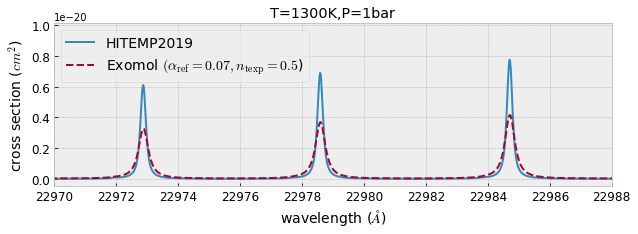

In [85]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(wav[::-1],xsv_HITEMP,lw=2,label="HITEMP2019")
plt.plot(wav[::-1],xsv_Li2015,lw=2,ls="dashed",label="Exomol $(\\alpha_\\mathrm{ref}=0.07,\
         n_\\mathrm{texp}=0.5$)")
plt.xlim(22970,22988)
plt.xlabel("wavelength ($\AA$)",fontsize=14)
plt.ylabel("cross section ($cm^{2}$)",fontsize=14)
plt.legend(loc="upper left",fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig("co_comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("co_comparison.png", bbox_inches="tight", pad_inches=0.0)
plt.title("T=1300K,P=1bar")
plt.show()

In [48]:
np.min(gammaL_HITEMP),np.max(gammaL_HITEMP)

(DeviceArray(0.01456154, dtype=float32),
 DeviceArray(0.02531094, dtype=float32))

In [49]:
np.min(gammaL_Li2015),np.max(gammaL_Li2015)

(DeviceArray(0.03263554, dtype=float32),
 DeviceArray(0.03263554, dtype=float32))